In [1]:
import torch
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from networks import *

In [3]:
from data_loader.data_loaders import MnistDataLoader

In [4]:
code_size = 100 
code_gen = CodeGenerator(code_size, noise_size=code_size)
encoder = Encoder(code_size)
decoder = Decoder(code_size)
disc_code = CodeDiscriminator(code_size)
disc_img = ImageDiscriminator()

In [5]:
n_gpu_use = 1
device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')

encoder = encoder.to(device)
decoder = decoder.to(device)
code_gen = code_gen.to(device)
disc_code = disc_code.to(device)
disc_img = disc_img.to(device)

optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=10e-4)
optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=10e-4)
optimizer_disc_img = torch.optim.Adam(disc_img.parameters(), lr=10e-4)
optimizer_disc_code = torch.optim.Adam(disc_code.parameters(), lr=10e-4)
optimizer_code_gen = torch.optim.Adam(code_gen.parameters(), lr=10e-4)

In [6]:
batch_size = 128
data_loader = MnistDataLoader('mnist_data', batch_size=batch_size, shuffle=True, validation_split=0.2, num_workers=1)

In [7]:
import torch, torchvision

traindataset = torchvision.datasets.MNIST('mnist_data', transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
data_loader = torch.utils.data.dataloader.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [8]:
# optimizer_G = torch.optim.Adam([encoder.parameters(), decoder.parameters()])
# optimizer_D = torch.optim.Adam([disc_code.parameters(), disc_img.parameters()])

dec_weight = 2

cross_entropy_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss() 

def train_epoch():
    enc_total_loss = 0
    dec_total_loss = 0
    disc_code_total_loss = 0
    disc_img_total_loss = 0
    
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        cur_batch_size = data.shape[0]
        # AAE phase
        z = torch.randn((cur_batch_size, code_size)).to(device)
#         code_gen.train(False)
#         disc_img.train(False)
#         encoder.train()
#         disc_code.train()
#         decoder.train()
        
#         optimizer_enc.zero_grad()
#         optimizer_disc_code.zero_grad()
#         optimizer_dec.zero_grad()

        z_code = code_gen(z)
        data_repr = encoder(data)
        data_rec = decoder(data_repr)

        loss_rec = mse_loss(disc_img(data_rec)[0], disc_img(data)[0].detach()) #.fmap
        disc_code_input = torch.cat((z_code, data_repr))
        disc_code_pred = disc_code(disc_code_input).reshape(2*cur_batch_size)
        disc_code_target = torch.cat((torch.ones(cur_batch_size), torch.zeros(cur_batch_size))).to(device)

        disc_code_gan_loss = cross_entropy_loss(disc_code_pred, disc_code_target)
        enc_loss = loss_rec - disc_code_gan_loss

        optimizer_enc.zero_grad()        
        enc_loss.backward(retain_graph=True)
        optimizer_enc.step()
        enc_total_loss += enc_loss.data.cpu().numpy().item()

        optimizer_disc_code.zero_grad()
        disc_code_gan_loss.backward(retain_graph=True)
        optimizer_disc_code.step()   
        disc_code_total_loss += disc_code_gan_loss.data.cpu().numpy().item()

        dec_loss = dec_weight*loss_rec
        optimizer_dec.zero_grad()
        dec_loss.backward(retain_graph=False)
        optimizer_dec.step()
        dec_total_loss += dec_loss.data.cpu().numpy().item()
        
        
        # Prior improvement phase
#         encoder.train(False)
#         disc_code.train(False)
#         code_gen.train()
#         disc_img.train()
#         decoder.train()
        
        z = torch.randn((cur_batch_size, code_size)).to(device)
        z_code = code_gen(z)
        x_sampled = decoder(z_code)
        data_repr = encoder(data)
        data_rec = decoder(data_repr)
        
        disc_img_input = torch.cat((x_sampled, data, data_rec))
        disc_img_pred = disc_img(disc_img_input)[0].reshape(3*cur_batch_size)
        disc_img_target = torch.cat((torch.zeros(cur_batch_size), torch.ones(cur_batch_size), torch.zeros(cur_batch_size))).to(device)
        disc_img_gan_loss = cross_entropy_loss(disc_img_pred, disc_img_target)
        
        optimizer_disc_img.zero_grad()
        optimizer_code_gen.zero_grad()
        disc_img_gan_loss.backward(retain_graph=True)
        optimizer_disc_img.step()
        
        disc_img_total_loss += disc_img_gan_loss.data.cpu().numpy().item()
        
        dec_loss = -disc_img_gan_loss
        optimizer_dec.zero_grad()
        dec_loss.backward(retain_graph=False)
        optimizer_dec.step()
        optimizer_code_gen.step()

        
    clear_output(wait=True)
    plt.imshow(((data_rec[1].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
    plt.savefig('log_img/'+str(i)+'.png')
    plt.show()
    print("enc_total_loss:", enc_total_loss)
    print("dec_total_loss:", dec_total_loss)
    print("disc_code_total_loss:", disc_code_total_loss)
    print("disc_img_total_loss:", disc_img_total_loss)
    print()

In [8]:
def get_model_norm_grad(model):
    cur_norm = 0
    for par in model.parameters():
        cur_norm = par.grad.norm()
    print(model.__class__.__name__, cur_norm)


In [9]:
enc_total_loss = 0
dec_total_loss = 0
disc_code_total_loss = 0
disc_img_total_loss = 0


dec_weight = 1

cross_entropy_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss() 


for batch_idx, (data, target) in enumerate(data_loader):
    data, target = data.to(device), target.to(device)
    cur_batch_size = data.shape[0]
    # AAE phase
    z = torch.randn((cur_batch_size, code_size)).to(device)
#     code_gen.train(False)
#     disc_img.train(False)
#     encoder.train()
#     disc_code.train()
#     decoder.train()
#         optimizer_enc.zero_grad()
#         optimizer_disc_code.zero_grad()
#         optimizer_dec.zero_grad()
    z_code = code_gen(z)
    data_repr = encoder(data)
    data_rec = decoder(data_repr)

    loss_rec = 2*torch.norm(disc_img(data_rec)[2]-disc_img(data)[2].detach())/cur_batch_size#mse_loss(disc_img(data_rec)[2], disc_img(data)[2].detach()) #.fmap
    disc_code_input = torch.cat((z_code, data_repr))
    disc_code_pred = disc_code(disc_code_input).reshape(2*cur_batch_size)
    disc_code_target = torch.cat((torch.ones(cur_batch_size), torch.zeros(cur_batch_size))).to(device)

    print("loss_rec:", loss_rec.item())
    
    disc_code_gan_loss = cross_entropy_loss(disc_code_pred, disc_code_target)
    print("disc_code_gan_loss:", disc_code_gan_loss.item())
    enc_loss = loss_rec - disc_code_gan_loss

    optimizer_code_gen.zero_grad()
    optimizer_enc.zero_grad()
    enc_loss.backward(retain_graph=True)
    optimizer_enc.step()
    enc_total_loss += enc_loss.data.cpu().numpy().item()

    optimizer_disc_code.zero_grad()
    disc_code_gan_loss.backward(retain_graph=True)
    optimizer_disc_code.step()   
    disc_code_total_loss += disc_code_gan_loss.data.cpu().numpy().item()
    dec_loss = dec_weight*loss_rec
    print("dec_loss:", dec_loss.item())  

    optimizer_dec.zero_grad()
    dec_loss.backward(retain_graph=True)
    get_model_norm_grad(decoder)
    optimizer_dec.step()
    dec_total_loss += dec_loss.data.cpu().numpy().item()
    
    # Prior improvement phase
#     encoder.train(False)
#     disc_code.train(False)
#     code_gen.train()
#     disc_img.train()
#     decoder.train()

    z = torch.randn((cur_batch_size, code_size)).to(device)
    z_code = code_gen(z)
    x_sampled = decoder(z_code)
    data_repr = encoder(data)
    data_rec = decoder(data_repr)

    disc_img_input = torch.cat((x_sampled, data, data_rec))
    disc_img_pred = disc_img(disc_img_input)[0].reshape(3*cur_batch_size)
    disc_img_target = torch.cat((torch.zeros(cur_batch_size), torch.ones(cur_batch_size), torch.zeros(cur_batch_size))).to(device)
    disc_img_gan_loss = 10*cross_entropy_loss(disc_img_pred, disc_img_target)
    print("disc_img_gan_loss:", disc_img_gan_loss.item())
    optimizer_disc_img.zero_grad()
    disc_img_gan_loss.backward(retain_graph=True)
    optimizer_disc_img.step()
    disc_img_total_loss += disc_img_gan_loss.data.cpu().numpy().item()

    dec_loss = -10*disc_img_gan_loss
    optimizer_dec.zero_grad()
    dec_loss.backward(retain_graph=False)
    get_model_norm_grad(decoder)
    optimizer_dec.step() 

    plt.imshow(((data_rec[0].data.cpu().numpy()+1)/2).reshape(28, 28), cmap='gray')
    plt.show()
    print(dec_loss)
    clear_output(wait=True)
    

loss_rec: 0.3631129562854767
disc_code_gan_loss: 3.9460774132749066e-05
dec_loss: 0.3631129562854767
Decoder tensor(1.00000e-02 *
       3.4719, device='cuda:0')
disc_img_gan_loss: 0.00044393076677806675


Process Process-6:
Process Process-5:
Process Process-2:
Process Process-7:
Process Process-1:
Process Process-8:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/pr

KeyboardInterrupt: 

In [13]:
import time

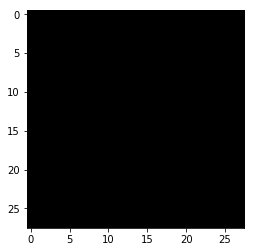

enc_total_loss: 80.97048492357135
dec_total_loss: 194.34900653886143
disc_code_total_loss: 16.2040184582861
disc_img_total_loss: 7.44602172388295

0


Process Process-11:
Process Process-15:
Process Process-9:
Process Process-12:
Traceback (most recent call last):
Process Process-14:
Process Process-16:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-10:
Process Process-13:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/

KeyboardInterrupt: 

In [9]:
for i in range(100):
    train_epoch()
    torch.save(encoder, "encoder")
    torch.save(decoder, "decoder")
    torch.save(disc_code, "disc_code")
    torch.save(disc_img, "disc_img")
    torch.save(code_gen, "code_gen")
    print(i)

In [10]:
for x, y in data_loader:
    x_enc = encoder(x.cuda())
    break

In [16]:
decoder = decoder.to(device)

In [18]:
x_rec = decoder(x_enc[0].unsqueeze(0))

In [11]:
for x, y in data_loader:
    x_rec = decoder(encoder(x.cuda()))
    break

In [22]:
x[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

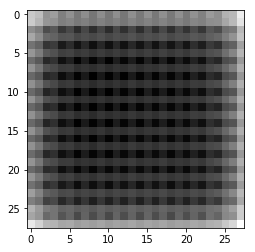

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(((x_rec[0].data.cpu().numpy()+1)/2).reshape(28, 28), cmap='gray')

In [16]:
x_rec[1].min()

tensor(-1., device='cuda:0')

In [65]:
x[1].data.cpu().numpy().reshape(28,28)

array([[-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.4242

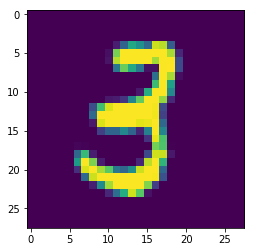

In [64]:
plt.imshow(x[1].data.cpu().numpy().reshape(28,28))

In [7]:


n_gpu_use = 1
device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')

encoder = encoder.to(device)
decoder = decoder.to(device)
code_gen = code_gen.to(device)
disc_code = disc_code.to(device)
disc_img = disc_img.to(device)

dec_weight = 2

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss() 


In [10]:
for batch_idx, (data, target) in enumerate(data_loader):
    data, target = data.to(device), target.to(device)

    # AAE phase
    z = torch.randn((batch_size, 8)).to(device)
    code_gen.train(False)
    disc_img.train(False)
    encoder.train()
    disc_code.train()
    decoder.train()

    z_code = code_gen(z)
    data_repr = encoder(data)
    data_rec = decoder(data_repr)
    loss_rec = mse_loss(disc_img(data_rec)[0], disc_img(data)[0].detach()) #.fmap
    disc_code_input = torch.cat((z_code, data_repr))
    disc_code_pred = disc_code(disc_code_input)
    disc_code_target = torch.cat((torch.ones(batch_size), torch.zeros(batch_size))).long().to(device)
    break 
    disc_code_gan_loss = cross_entropy_loss(disc_code_pred, disc_code_target)


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [12]:
cross_entropy_loss(disc_code_pred, disc_code_target)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:70

In [11]:
disc_img(data_rec)[0]

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]]], device='cuda:0')

In [13]:
cross_entropy_loss(disc_code_pred, disc_code_target.long())

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:70

In [14]:
loss_rec.backward()